In [1]:
!pip install stop_words
!pip install pymorphy2

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32916 sha256=4b0eb5eb172b7d403d12849916b54eee0d2bb110759c1080cc82a65663b01961
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
     |████████████████████████████████| 51kB 1.8MB/s 
     |████████████████████████████████| 7.1MB 5.8MB/s 


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from string import punctuation
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download("punkt")
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import multiprocessing

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
max_words = 2000
max_len = 50

# Training
epochs = 150
batch_size = 512

In [7]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [8]:
def preprocess_text(txt):
    txt = str(txt)
    txt = re.sub(r'( )+', " ", re.sub(r'[^\w\s]', " ", txt)).strip()
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    txt = re.sub("\sне", "не", txt)
    return txt

In [9]:
otzivy_za_leto = pd.read_excel("/content/drive/My Drive/Нейронные сети/Neural Language Processing/Lesson 5/отзывы за лето.xls", )

In [10]:
test_text = otzivy_za_leto.iloc[450]["Content"]
print(test_text)
preprocessed_test_text = preprocess_text(test_text)
print(type(preprocessed_test_text))
print(preprocessed_test_text)

Отличное приложение, всё удобно и понятно, приятный интерфейс. Иногда приходится пользоваться приложением от ВТБ просто отвратительно во всём. Спасибо! Спустя год: не могу делать переводы вне шаблонов после обновления. Даже не знаю зачем пишу, всё равно никто не читает и оперативно не решает проблемы. Самсунг мини 4.
<class 'str'>
отличный приложение удобно понятно приятный интерфейс приходиться пользоваться приложение втб отвратительный весь спустя мочь делать перевод вне шаблон обновление знать писать равно никто читать оперативно решать проблема самсунг минь 4


In [11]:
otzivy_za_leto.Rating.unique()

array([5, 4, 2, 3, 1])

In [12]:
# for to_categorical usage
otzivy_za_leto.Rating = otzivy_za_leto.Rating - 1

In [13]:
otzivy_za_leto.head()

,Rating,Content,Date
0,4,It just works!,2017-08-14
1,3,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,4,Отлично все,2017-08-14
3,4,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,4,"Очень удобно, работает быстро.",2017-08-14


In [14]:
otzivy_za_leto.Rating.unique()

array([4, 3, 1, 2, 0])

In [15]:
vfunc = np.vectorize(preprocess_text)

In [16]:
%%time
otzivy_za_leto["text"] = vfunc(otzivy_za_leto.Content)
otzivy_za_leto.head()

CPU times: user 13.9 s, sys: 74.9 ms, total: 13.9 s
Wall time: 13.9 s


In [17]:
train_corpus = " ".join(otzivy_za_leto["text"])
train_corpus = train_corpus.lower()

In [18]:
tokens = word_tokenize(train_corpus)

In [19]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [20]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [21]:
tokens_filtered_top[:20]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'телефон',
 'отличный',
 'супер',
 'обновление',
 'быстро',
 'пароль',
 'пользоваться',
 'мочь',
 'антивирус',
 'сбербанк',
 'раз',
 'устраивать',
 'вход']

In [22]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [23]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [24]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in otzivy_za_leto["text"]], dtype=np.int32)

In [25]:
otzivy_za_leto["Rating"].unique()

array([4, 3, 1, 2, 0])

In [26]:
num_classes = len(otzivy_za_leto["Rating"].unique())
num_classes

5

In [27]:
y_train = keras.utils.to_categorical(otzivy_za_leto["Rating"], num_classes)

In [28]:
keras.backend.clear_session()

embed_vec_len = 50

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_")(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len*10, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(64, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(64, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 50)]              0         
_________________________________________________________________
Embed_ (Embedding)           (None, 50, 50)            100000    
_________________________________________________________________
Conv1_ (Conv1D)              (None, 46, 500)           125500    
_________________________________________________________________
GlobMaxPool1 (GlobalMaxPooli (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
Dense1_ (Dense)              (None, 64)                32064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0  

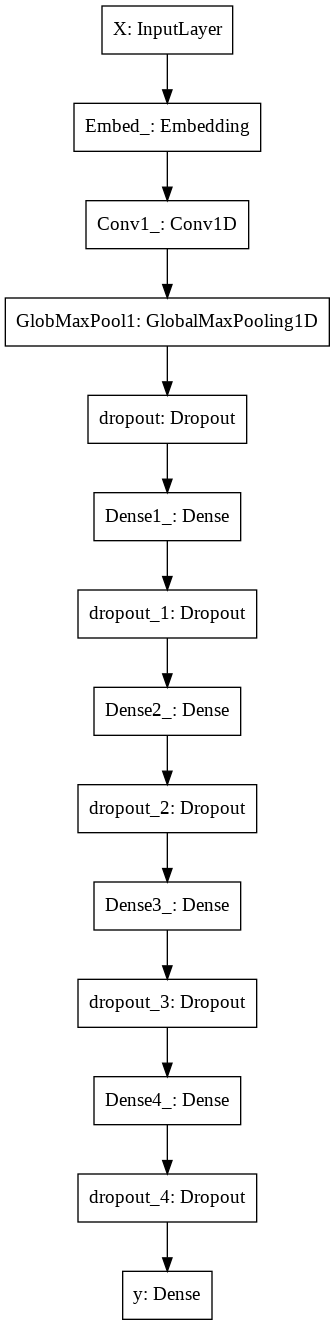

In [30]:
tf.keras.utils.plot_model(model)

In [31]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    )

Epoch 1/150
33/33 [==============================] - 1s 26ms/step - loss: 1.3004 - accuracy: 0.5666 - val_loss: 1.0952 - val_accuracy: 0.6227
Epoch 2/150
33/33 [==============================] - 1s 15ms/step - loss: 0.9951 - accuracy: 0.6983 - val_loss: 0.9055 - val_accuracy: 0.6227
Epoch 3/150
33/33 [==============================] - 1s 16ms/step - loss: 0.8535 - accuracy: 0.7159 - val_loss: 0.8609 - val_accuracy: 0.6227
Epoch 4/150
33/33 [==============================] - 0s 15ms/step - loss: 0.7931 - accuracy: 0.7201 - val_loss: 0.8449 - val_accuracy: 0.6227
Epoch 5/150
33/33 [==============================] - 1s 15ms/step - loss: 0.7546 - accuracy: 0.7240 - val_loss: 0.8476 - val_accuracy: 0.6227
Epoch 6/150
33/33 [==============================] - 0s 15ms/step - loss: 0.7358 - accuracy: 0.7244 - val_loss: 0.8481 - val_accuracy: 0.6227
Epoch 7/150
33/33 [==============================] - 1s 16ms/step - loss: 0.7177 - accuracy: 0.7274 - val_loss: 0.8445 - val_accuracy: 0.6227
Epoch 

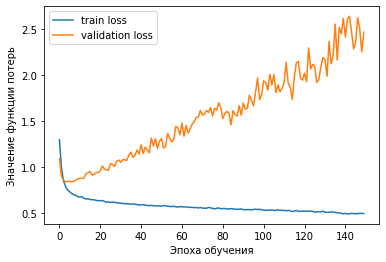

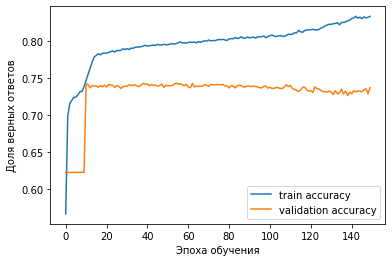

In [32]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

Тренировка word2vec с использованием полученных весов в качестве эмбедингов

In [33]:
sentences_list_of_lists = [[sentence] for sentence in otzivy_za_leto.text.tolist()]
sentences_list_of_lists[:10]

[['it just works'],
 ['целое удобноной приложение минус хотеть большой доступ персональный данные телефон приходиться пользоваться ограниченный режим'],
 ['отлично'],
 ['зависать 1 работа антивирус ранее пользоваться нормальный'],
 ['удобно работать быстро'],
 ['удобно норма'],
 ['удобный приложение'],
 ['устраивать'],
 ['работать чётко отличие банкомат вечно зависать тупить'],
 ['']]

In [34]:
modelW2V = Word2Vec(sentences=sentences_list_of_lists, size=embed_vec_len, window=10, min_count=2, workers=multiprocessing.cpu_count())

In [35]:
buffer = np.random.random((max_words,embed_vec_len))
buffer

array([[0.66402816, 0.57070748, 0.87443182, ..., 0.25507807, 0.28433936,
        0.36661213],
       [0.76288064, 0.16623205, 0.75367248, ..., 0.85879059, 0.03125199,
        0.98791026],
       [0.53955926, 0.95510888, 0.38766419, ..., 0.53943991, 0.28596332,
        0.11627416],
       ...,
       [0.18025804, 0.64765052, 0.35939763, ..., 0.64122087, 0.95386593,
        0.01336744],
       [0.00593675, 0.46022718, 0.27132616, ..., 0.15557034, 0.7498896 ,
        0.05488831],
       [0.84272448, 0.96048392, 0.14737292, ..., 0.03341934, 0.99062321,
        0.61650036]])

In [36]:
for word in vocabulary:
    if word in modelW2V.wv:
#         print(word, modelW2V.wv[word])
        buffer[vocabulary[word]] = modelW2V.wv[word]

Зафиксированные Embedding-и после инициализации

In [37]:
keras.backend.clear_session()

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_", weights=[buffer], trainable=False)(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(64, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(64, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    )

Epoch 1/150
33/33 [==============================] - 0s 10ms/step - loss: 1.6118 - accuracy: 0.4839 - val_loss: 1.4412 - val_accuracy: 0.6227
Epoch 2/150
33/33 [==============================] - 0s 5ms/step - loss: 1.2887 - accuracy: 0.6598 - val_loss: 1.1949 - val_accuracy: 0.6227
Epoch 3/150
33/33 [==============================] - 0s 5ms/step - loss: 1.1422 - accuracy: 0.7127 - val_loss: 1.1037 - val_accuracy: 0.6227
Epoch 4/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0856 - accuracy: 0.7199 - val_loss: 1.0622 - val_accuracy: 0.6227
Epoch 5/150
33/33 [==============================] - 0s 5ms/step - loss: 1.0376 - accuracy: 0.7217 - val_loss: 1.0052 - val_accuracy: 0.6227
Epoch 6/150
33/33 [==============================] - 0s 6ms/step - loss: 0.9908 - accuracy: 0.7231 - val_loss: 0.9848 - val_accuracy: 0.6227
Epoch 7/150
33/33 [==============================] - 0s 6ms/step - loss: 0.9705 - accuracy: 0.7249 - val_loss: 0.9730 - val_accuracy: 0.6227
Epoch 8/150


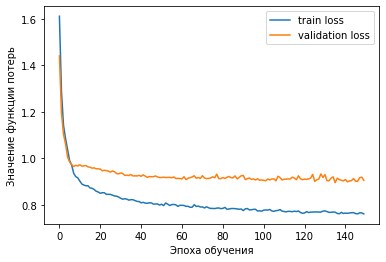

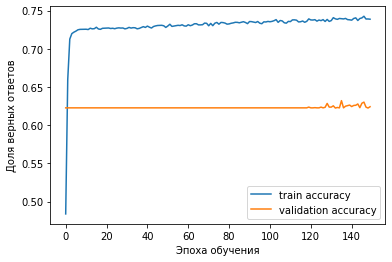

In [39]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

### Embedding-и дотренировываются после инициализации

In [40]:
keras.backend.clear_session()

X_input = tf.keras.layers.Input(shape=(max_len,), name="X")
Embed_ = tf.keras.layers.Embedding(input_dim=max_words, output_dim=embed_vec_len, name="Embed_", weights=[buffer], trainable=True)(X_input)
Conv1_ = tf.keras.layers.Conv1D(filters=embed_vec_len, kernel_size=5, activation="relu", name="Conv1_")(Embed_)
GlobMaxPool1_ = tf.keras.layers.GlobalMaxPool1D(name="GlobMaxPool1")(Conv1_)
Drop1_ = tf.keras.layers.Dropout(0.6)(GlobMaxPool1_)
Dense1_ = tf.keras.layers.Dense(64, activation="relu", name="Dense1_")(Drop1_)
Drop2_ = tf.keras.layers.Dropout(0.6)(Dense1_)
Dense2_ = tf.keras.layers.Dense(64, activation="relu", name="Dense2_")(Drop2_)
Drop3_ = tf.keras.layers.Dropout(0.6)(Dense2_)
Dense3_ = tf.keras.layers.Dense(32, activation="relu", name="Dense3_")(Drop3_)
Drop4_ = tf.keras.layers.Dropout(0.6)(Dense3_)
Dense4_ = tf.keras.layers.Dense(32, activation="relu", name="Dense4_")(Drop4_)
Drop5_ = tf.keras.layers.Dropout(0.75)(Dense4_)
y_output = tf.keras.layers.Dense(num_classes, activation="softmax", name="y")(Drop5_)

model = tf.keras.models.Model(inputs=[X_input], outputs=[y_output], name="my_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [41]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,
                    )

Epoch 1/150
33/33 [==============================] - 0s 12ms/step - loss: 1.7631 - accuracy: 0.4840 - val_loss: 1.5341 - val_accuracy: 0.6227
Epoch 2/150
33/33 [==============================] - 0s 8ms/step - loss: 1.4429 - accuracy: 0.6784 - val_loss: 1.3830 - val_accuracy: 0.6227
Epoch 3/150
33/33 [==============================] - 0s 8ms/step - loss: 1.2689 - accuracy: 0.6877 - val_loss: 1.1921 - val_accuracy: 0.6227
Epoch 4/150
33/33 [==============================] - 0s 8ms/step - loss: 1.1422 - accuracy: 0.7110 - val_loss: 1.0987 - val_accuracy: 0.6227
Epoch 5/150
33/33 [==============================] - 0s 8ms/step - loss: 1.0709 - accuracy: 0.7208 - val_loss: 1.0176 - val_accuracy: 0.6227
Epoch 6/150
33/33 [==============================] - 0s 8ms/step - loss: 1.0110 - accuracy: 0.7223 - val_loss: 0.9836 - val_accuracy: 0.6227
Epoch 7/150
33/33 [==============================] - 0s 8ms/step - loss: 0.9830 - accuracy: 0.7236 - val_loss: 0.9793 - val_accuracy: 0.6227
Epoch 8/150


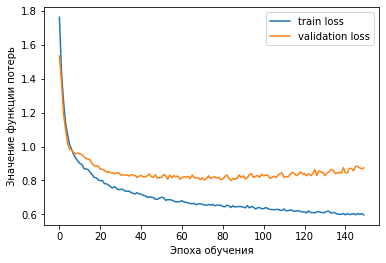

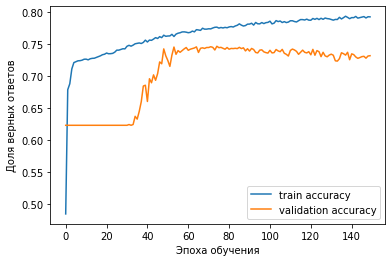

In [42]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

При инициализации точность получилась примерно 0,72, без инициализации, без инициализации чуть больше. Но потери на валиде при этом больше чем при инициализации